# Filling up missing data with cluster algorithm

机器学习模型的最终效果取决于其中两个重要因素：
- 数据的质量
- 数据汇总蕴含的游泳信息的数量

实际应用中，样本由于各种原因导致某些属性数据缺失，常用的处理方法是：
- 对于数值类型的数据，填充为平均值、中值等统计数值；
- 对于类别类型的数据，填充为出现次数最多的类别；

此类方法统计计算的值为全局数据集范围内，所以考虑结合聚类算法，在某一簇内计算统计值进行填充。

## 1. Iterative EM-type algorithm


    1. Initialize missing values to their column means
    2. Repeat until convergence:
        2.1 Perform K-means clustering on the filled-in data
        2.2 Set the missing values to the centroid coordinates of the clusters to which they were assigned


### Implementation

In [1]:
import numpy as np
from sklearn.cluster import KMeans

def kmeans_missing(X, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.

    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.

    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    for i in xrange(max_iter):
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much
            # faster and makes it easier to check convergence (since labels
            # won't be permuted on every iteration), but might be more prone to
            # getting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids)
        else:
            # do multiple random initializations in parallel
            cls = KMeans(n_clusters, n_jobs=-1)

        # perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_

        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return labels, centroids, X_hat

### Example with fake data

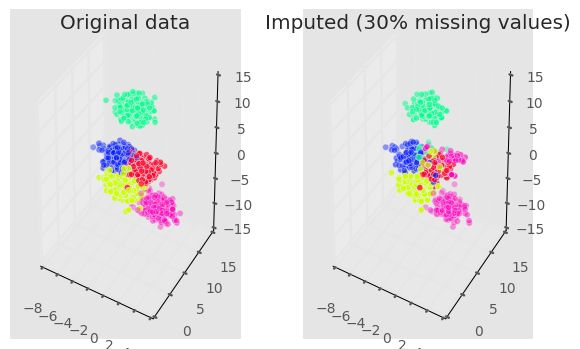

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')

from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def make_fake_data(fraction_missing, n_clusters=5, n_samples=1500,
                   n_features=3, seed=None):
    # complete data
    gen = np.random.RandomState(seed)
    X, true_labels = make_blobs(n_samples, n_features, n_clusters,
                                random_state=gen)
    # with missing values
    missing = gen.rand(*X.shape) < fraction_missing
    Xm = np.where(missing, np.nan, X)
    return X, true_labels, Xm


X, true_labels, Xm = make_fake_data(fraction_missing=0.3, n_clusters=5, seed=0)
labels, centroids, X_hat = kmeans_missing(Xm, n_clusters=5)

# plot the inferred points, color-coded according to the true cluster labels
fig, ax = plt.subplots(1, 2, subplot_kw={'projection':'3d', 'aspect':'equal'})
ax[0].scatter3D(X[:, 0], X[:, 1], X[:, 2], c=true_labels, cmap='gist_rainbow')
ax[1].scatter3D(X_hat[:, 0], X_hat[:, 1], X_hat[:, 2], c=true_labels,
                cmap='gist_rainbow')
ax[0].set_title('Original data')
ax[1].set_title('Imputed (30% missing values)')
fig.tight_layout()